# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [16]:
### Load pickled data and size check

import pickle
import numpy as np

#Fill this in based on where you saved the training and testing data
training_file = 'traffic_signs_data/train.p'
validation_file= 'traffic_signs_data/valid.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_src, y_train = train['features'], train['labels']
X_valid_src, y_valid = valid['features'], valid['labels']
X_test_src, y_test = test['features'], test['labels']

#Verification
assert(len(X_train_src) == len(y_train))
assert(len(X_valid_src) == len(y_valid))
assert(len(X_test_src) == len(y_test))

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [17]:
### Init values of dataset sizes

#Number of training examples
n_train = len(X_train_src)

#Number of validation examples
n_validation = len(X_valid_src)

#Number of testing examples.
n_test = len(X_test_src)

#What's the shape of an traffic sign image?
image_shape = X_train_src[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(set(y_valid))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [18]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [19]:
# Creating dictionary ClassId -> NameStr
import csv

signnames_file = 'signnames.csv'
signs_dict = {}
with open(signnames_file) as signnames:
    reader = csv.DictReader(signnames, delimiter=',')
    for row in reader:
        signs_dict[int(row['ClassId'])] = row['SignName']

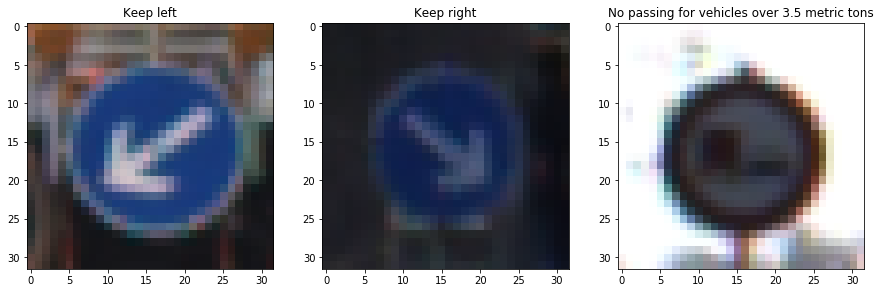

In [20]:
### Displaying some images from validation dataset
import random

demo_pic_cnt = 3

plt.figure(figsize=(15,10))
for i in range(demo_pic_cnt):
    index = random.randint(0, len(X_valid_src))
    demo_img_src = X_valid_src[index]
    title_str_src = signs_dict[y_valid[index]]

    plt.subplot(1, demo_pic_cnt, i+1)
    plt.imshow(demo_img_src)
    plt.title(title_str_src)

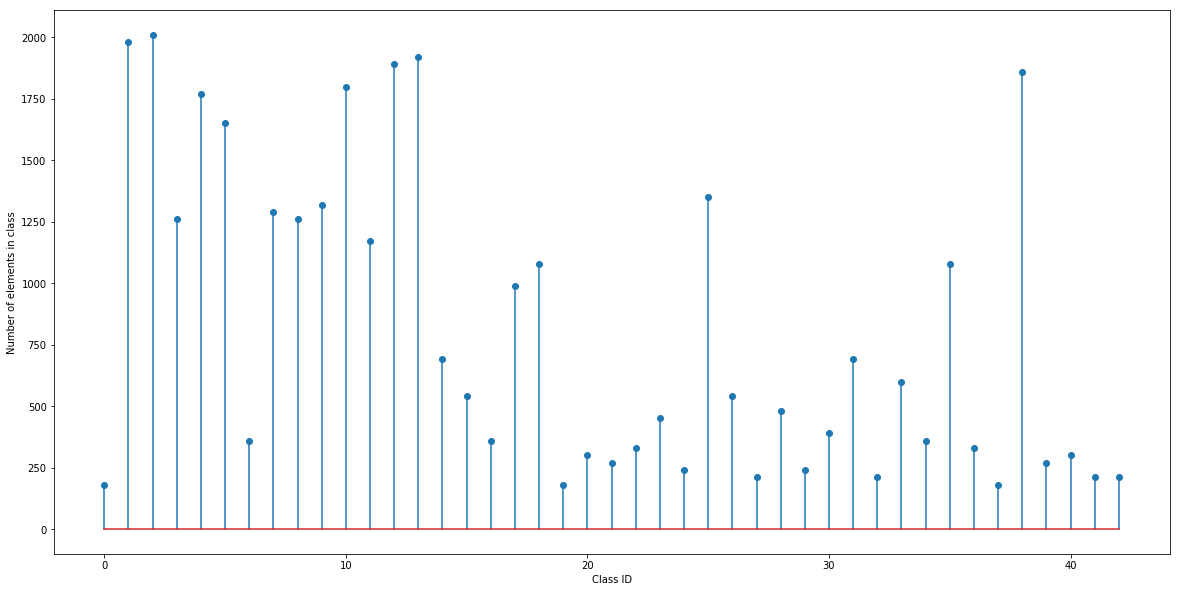

In [21]:
### Counting and plotting number of images per class id


id_cnt = np.array([[idx, y_train.tolist().count(idx)] for idx in set(y_train.tolist())])

plt.figure(figsize=(20,10))
plt.stem(id_cnt[:,0], id_cnt[:,1])
plt.xlabel('Class ID');
plt.ylabel('Number of elements in class')

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

In [22]:
### Data preprocessing
import numpy as np

def normalize_data(X):
    X_res = np.zeros(X.shape, dtype=float)
    for i in range(len(X)):
        img = X[i].astype(dtype=float)
        img -= np.min(img)
        img /= np.max(img)
        X_res[i] = img
    return X_res
        
X_train = normalize_data(X_train_src)
X_valid = normalize_data(X_valid_src)
X_test = normalize_data(X_test_src)

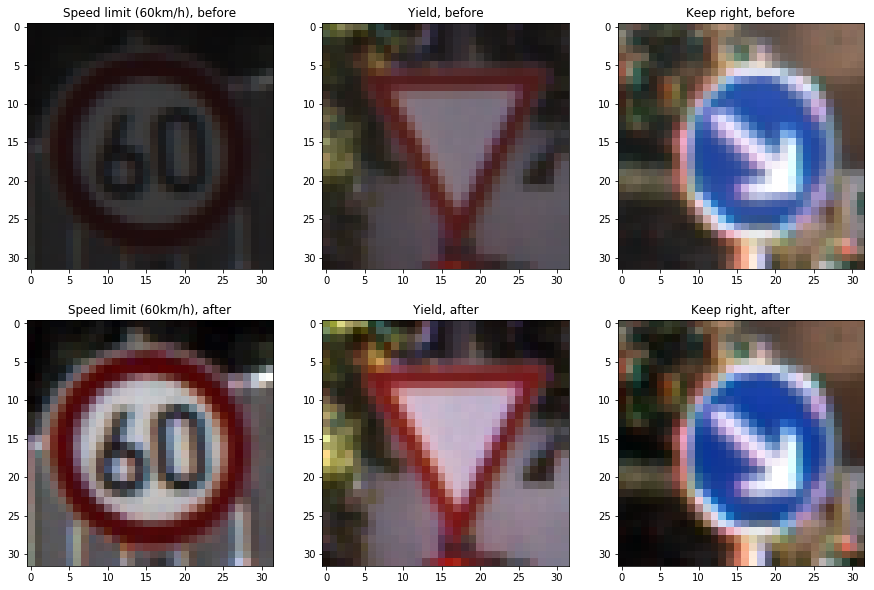

In [24]:
# Displaying image preprocessing and normalisation
import random

demo_pic_cnt = 3

plt.figure(figsize=(15,10))
for i in range(demo_pic_cnt):
    index = random.randint(0, len(X_valid))
    demo_img_src = X_valid_src[index]
    demo_img = X_valid[index]
    
    title_str_src = signs_dict[y_valid[index]] + ', before'
    title_str = signs_dict[y_valid[index]] + ', after'

    plt.subplot(2, demo_pic_cnt, i+1)
    plt.imshow(demo_img_src)
    plt.title(title_str_src)
    
    plt.subplot(2, demo_pic_cnt, i+1+demo_pic_cnt)
    plt.imshow(demo_img)
    plt.title(title_str)

### Model Architecture

In [25]:
### LeNet architecture with 32*32*3 input size

from tensorflow.contrib.layers import flatten


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return x


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


def LeNet(x, keep_probability):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    n_classes = 43
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'wfc1':tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma)),
        'wfc2':tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))}

    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([16], mean=mu, stddev=sigma)),
        'bfc1':tf.Variable(tf.truncated_normal([120], mean=mu, stddev=sigma)),
        'bfc2':tf.Variable(tf.truncated_normal([84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))}
    
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], 1)
    
    #Activation.
    conv1 = tf.nn.relu(conv1)
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1p = maxpool2d(conv1, 2)
    
    #Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1p, weights['wc2'], biases['bc2'], 1)
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2p = maxpool2d(conv2, 2)                   
    
    #Flatten. Input = 5x5x16. Output = 400.
    conv2p = tf.contrib.layers.flatten(conv2p)                  
        
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(conv2p, weights['wfc1']), biases['bfc1'])

    #Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_probability)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wfc2']), biases['bfc2'])
    
    #Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_probability)
    
    #Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits, conv1

In [26]:
### Network for testing purposes (not used in trainig, just for debugging purpose)
def TestNet(x, keep_probability):  
    
    mu = 0
    sigma = 0.1
    n_classes = 43
    weights = {'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma)),
               'wfc1out':tf.Variable(tf.truncated_normal([4704, n_classes], mean=mu, stddev=sigma))}
    biases = {'bc1': tf.Variable(tf.truncated_normal([6], mean=mu, stddev=sigma)), 
              'bfc1out':tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma)),}
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], 1)
    
    #Flatten. Input = 28x28x6. Output = 4704.
    conv2 = tf.contrib.layers.flatten(conv1)
    
    logits = tf.add(tf.matmul(conv2, weights['wfc1out']), biases['bfc1out'])
    
    return logits

### Train, Validate and Test the Model

In [76]:
### Setting down network parameters

import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 512
rate = 0.001

In [77]:
### Initial declaration

#batch place holders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

#Dropout variable
keep_probability = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

In [78]:
### Network pipeline

# layer_out will be used to show weight activation on a custom data input
[logits, layer_out] = LeNet(x, keep_probability)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [79]:
### Model evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    dropout = 1.0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [80]:
### Model train

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        dropout = 0.4
#         dropout = 0.5
#         dropout = 0.7
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: dropout})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.222

EPOCH 2 ...
Validation Accuracy = 0.416

EPOCH 3 ...
Validation Accuracy = 0.502

EPOCH 4 ...
Validation Accuracy = 0.586

EPOCH 5 ...
Validation Accuracy = 0.663

EPOCH 6 ...
Validation Accuracy = 0.726

EPOCH 7 ...
Validation Accuracy = 0.745

EPOCH 8 ...
Validation Accuracy = 0.786

EPOCH 9 ...
Validation Accuracy = 0.821

EPOCH 10 ...
Validation Accuracy = 0.827

EPOCH 11 ...
Validation Accuracy = 0.854

EPOCH 12 ...
Validation Accuracy = 0.870

EPOCH 13 ...
Validation Accuracy = 0.864

EPOCH 14 ...
Validation Accuracy = 0.876

EPOCH 15 ...
Validation Accuracy = 0.884

EPOCH 16 ...
Validation Accuracy = 0.895

EPOCH 17 ...
Validation Accuracy = 0.903

EPOCH 18 ...
Validation Accuracy = 0.912

EPOCH 19 ...
Validation Accuracy = 0.912

EPOCH 20 ...
Validation Accuracy = 0.912

EPOCH 21 ...
Validation Accuracy = 0.923

EPOCH 22 ...
Validation Accuracy = 0.918

EPOCH 23 ...
Validation Accuracy = 0.925

EPOCH 24 ...
Validation Accura

In [81]:
### Evaluation of model on test dataset

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

    valid_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Train Accuracy = 0.992
Validation Accuracy = 0.951
Test Accuracy = 0.930


---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [82]:
### Reading custom data from internet to variable

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

path = 'my_data/cropped/sized/*.bmp'
files = glob.glob(path)

batch_size = len(files)
batch_x = np.zeros((batch_size, 32, 32, 3), dtype=np.uint8)

for i in range(batch_size):
    img = cv2.imread(files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    batch_x[i, :, :, :] = np.copy(img)

X_mydata = normalize_data(batch_x)

In [83]:
### Reading the csv-file with class id number and its name pairs

import csv

# Create Dictionary
signnames_file = 'signnames.csv'
signs_dict = {}
with open(signnames_file) as signnames:
    reader = csv.DictReader(signnames, delimiter=',')
    for row in reader:
        signs_dict[int(row['ClassId'])] = row['SignName']

### Predict the Sign Type for Each Image

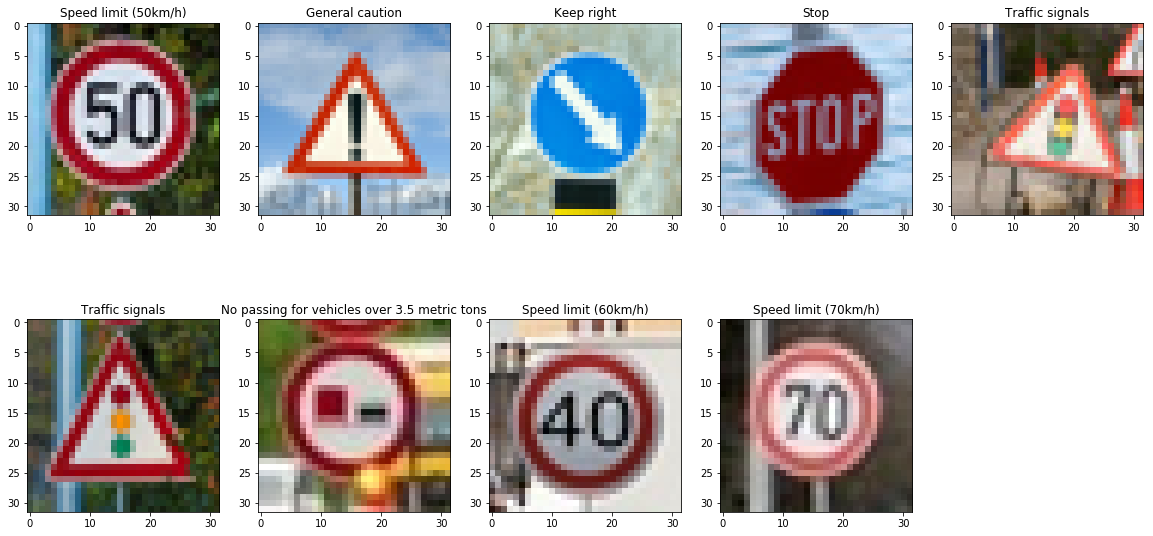

In [84]:
### Processing custom data and visualizating results

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = tf.argmax(tf.nn.softmax(logits), 1)
    top_k      = tf.nn.top_k(tf.nn.softmax(logits), k=5)
    dropout = 1
    results, probabilities = sess.run([prediction, top_k], feed_dict={x: X_mydata, keep_probability: dropout})


columns = 5
plt.figure(figsize=(20,10))
for i in range(len(X_mydata)):
    plt.subplot(len(X_mydata) / columns + 1, columns, i + 1)
    plt.imshow(X_mydata[i])
    plt.title(signs_dict[results[i]])


### Analyze Performance

In [85]:
### Performance calculation

total_num = len(X_mydata)
correct_num = 8
mydata_accuracy = correct_num / total_num

print("Accuracy for custom data from internet is %.3f" % mydata_accuracy)

Accuracy for custom data from internet is 0.889


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [86]:
### Printing pseudoprobabilities and classes

np.set_printoptions(precision = 8, suppress = True)

print(probabilities.values)
print(probabilities.indices)
print("\n")

top_k_num = 5

for i in range(len(X_mydata)):
#     print("| Probability         	|     Prediction	        					|")
#     print("|:---------------------:|:---------------------------------------------:|")
    print("Pic %d" % (i+1))
    for j in range(top_k_num):
        print("|%0.3f | %s" % (probabilities.values[i,j], signs_dict[probabilities.indices[i,j]]))

[[ 0.98589236  0.0141077   0.          0.          0.        ]
 [ 1.          0.00000004  0.00000001  0.          0.        ]
 [ 0.99991381  0.00008616  0.          0.          0.        ]
 [ 0.99999964  0.00000031  0.          0.          0.        ]
 [ 0.76043898  0.23720765  0.00082434  0.00068932  0.00029497]
 [ 0.99715745  0.00284255  0.          0.          0.        ]
 [ 0.99977821  0.00013049  0.00004607  0.00003806  0.00000529]
 [ 0.9984144   0.00158515  0.00000029  0.00000015  0.00000002]
 [ 0.99602145  0.00386606  0.00006033  0.00002478  0.00002069]]
[[ 2  1  4  0  3]
 [18 26 27 11 24]
 [38 34 36 13 32]
 [14 15  3 13  5]
 [26 18 25 27 22]
 [26 18 27 11 17]
 [10  9  2  7  5]
 [ 3  5 35 13 15]
 [ 4  0  1 37 17]]


Pic 1
|0.986 | Speed limit (50km/h)
|0.014 | Speed limit (30km/h)
|0.000 | Speed limit (70km/h)
|0.000 | Speed limit (20km/h)
|0.000 | Speed limit (60km/h)
Pic 2
|1.000 | General caution
|0.000 | Traffic signals
|0.000 | Pedestrians
|0.000 | Right-of-way at the next 

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



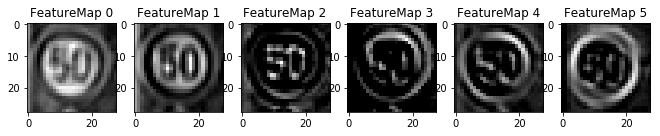

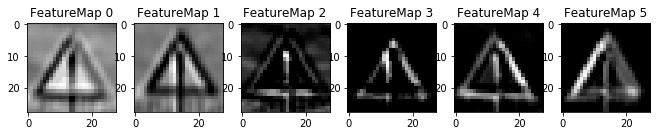

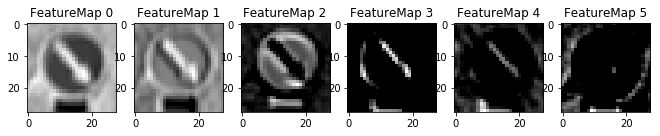

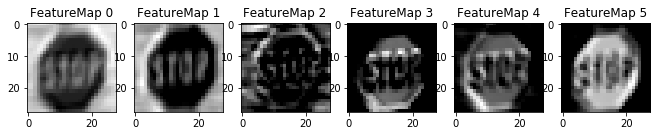

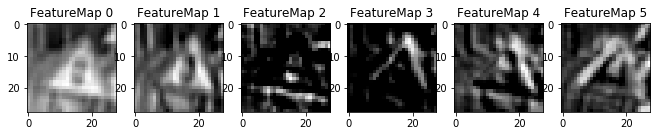

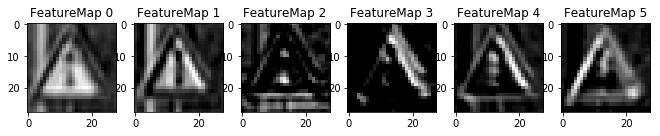

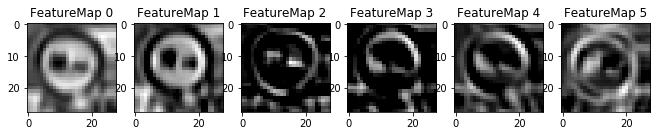

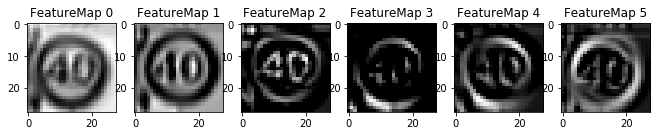

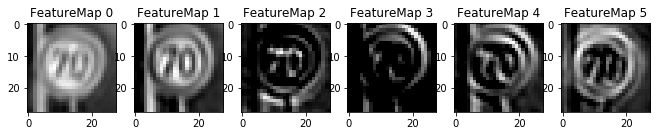

In [87]:
### Visualization of a two first layers bypassing by the custom data
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = sess.run(tf_activation, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for i in range(len(X_mydata)):
        test_input = np.expand_dims(X_mydata[i],0)
        outputFeatureMap(test_input, layer_out, plt_num=i+1)